# DARTS: Differentiable ARchiecTure Search

Link to the paper: [DARTS: DIFFERENTIABLE ARCHITECTURE SEARCH](https://arxiv.org/abs/1806.09055).

This paper, published in 2019, proposes a way to automatically find the optimal architecture of a neural network, which is traditionnaly kind of empirical.

More precisely, **it adresses the scalability challenge of architecture search by formulating the task in a differentiable manner**. Do not worry, we will soon explain what it is !

Extensive experiments on CIFAR-10, ImageNet, Penn Treebank and WikiText-2 show that the algorithm excels in discovering high-performance convolutional architectures for image classification and recurrent architectures for language modeling, while being orders of magnitude faster than state-of-the-art non-differentiable techniques.

The implementation has been made publicly available at [DARTS github repository](https://github.com/quark0/darts). Unfortunately, the lack of code maintenance makes it really hard to use and to understand today, so I will not use it in this notebook.

This notebook has been designed to be run on google colab.

<div class="alert alert-success">

**Learning outcomes**  
By the end of this notebook, you should be able to:
- Explain what is Neural Architecture Search.
- Explain what are the operations, cells and the nodes in this framework.
- Explain how DARTS is doing to relax the problem.
- Explain the bilevel optimisation problem at stake here.
- Understand the complexity of such a problem, and implement it on an easy example.
</div>

## Introduction to Neural Architecture Search (NAS)

Before delving into the paper and Differentiable ARchiTecture Search (DARTS), we need to lay the foundations of Neural Architecture Search (NAS).

The general problem can be posed as follows:

**Given a set of search space operations O, we need to find the combination of these operations that maximizes or minimizes the objective function.**

In the following example, we aim at predicting if an image is a dog or not.

In a classical workflow, we would first fix the architecture of the network, e.g. a network with 2 convolutional layers and 1 pooling layer, before finding the best hyperparameters within each layer.

NAS aims at **both predicting which is the best architecture and which are the optimal weights**. Here, the type of layers are called operations, and the goal is to find automatically which operation is the best. The gif depicts this only for the first layer of the network but this can be extented to any other layer.





In [ ]:
### Run this cell to see the animation ###
from IPython.display import Image
Image(url='https://upload.wikimedia.org/wikipedia/commons/1/1b/Neural_Architecture_Search.gif')

The naive approach consists in testing all the different configurations, but this is obviously incredibly demanding in computer power and thus is not optimal.

Here are some influential papers that each propose a way to tackle the NAS:

- [Neural Architecture Search with Reinforcement Learning](https://archive.ph/YCv6l)
- [Efficient Neural Architecture Search via Parameter Sharing](https://arxiv.org/abs/1802.03268)
- [Progressive Neural Architecture search](https://arxiv.org/pdf/1712.00559.pdf)


The biggest issue is that the best existing architecture search algorithms before DARTS are computationally demanding despite their remarkable performance.

Indeed, obtaining a state-of-the-art architecture for CIFAR-10 and ImageNet required 2000 GPU days of reinforcement learning ([Learning Transferable Architectures for Scalable Image Recognition](https://arxiv.org/abs/1707.07012)) or 3150 GPU days of evolution ([Regularized Evolution for Image Classifier Architecture Search](https://arxiv.org/abs/1802.01548)) to a few GPU days for DARTS.

Let's see the framework of DARTS and try to understand why it is so effective.

## How does DARTS work ?

### Framework

Now it's time to formalize.

Overall, a network will be made up of cells, and each cell will be made of nodes. The cells are the building blocks of the architecture: they can either be stacked to form a convolutional network or recursively connected to form a recurrent network.

More precisely, each cell is a directed acyclic graph (see [DAG introduction](https://www.geeksforgeeks.org/introduction-to-directed-acyclic-graph/) if you are not familiar) consisting of an ordered sequence of N nodes.

Each intermediate node is computed based on all of its predecessors: $x^{(j)}=\sum_{i<j} o^{(i, j)}\left(x^{(i)}\right)$, where each node $x^{(i)}$ is a latent representation and each directed edge $(i,j)$ is associated with some operation $o^{(i,j)} \in \mathcal{O}$ that transforms $x^{(i)}$.

**I want to strongly emphasize the point that the operation set can include any operation (e.g. convolution, max pooling, zero) which allows for a wide variety of final architectures.**

In the following example, there are 4 nodes.

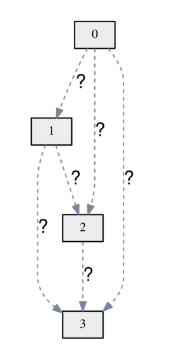

This drawing has one little defect: it does not show the 2 input nodes and the one terminal node, that are not directly counted in the number of nodes per cell. For convolutional cells, the input nodes are the cell outputs of the previous two layers. For recurrent cells, these are defined as the input at the current step and the output of the previous layer.

The output of the cell is obtained by applying a reduction operation (typically a concatenation) to all the intermediate nodes.

Here is depicted a convolutional cell with 3 inner nodes:

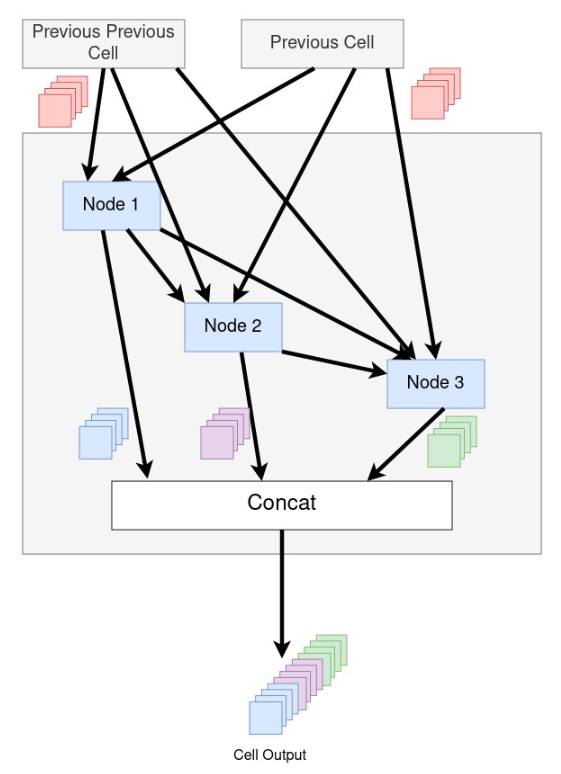

Now that everything is in place, we still have to understand how the operations between each node can be chosen effectively. Indeed, a naive test of all the different configurations is not possible because the model has to be trained on every specific configuration before moving on to the next configuration.

A clever work-around has to be found in order to relax the problem, and this is what we will see in the next part.

### Continuous relaxation and optimization

**One of the key idea of the paper is switching from a discrete optimisation problem to a continuous one in order to take advantage of the power and speed of gradient descent.**


In order to do so, the paper introduces the operation mixing weights for a pair of nodes $(i,j)$, which are parameterized by a vector $\alpha^{(i, j)}$ of dimension $|\mathcal{O}|$.

Each final operation between two nodes of a given cell is, after the optimisation is run, a softmax mixing of the $|\mathcal{O}|$ elementary operations:

$\bar{o}^{(i, j)}(x)=\sum_{o \in \mathcal{O}} \frac{\exp \left(\alpha_o^{(i, j)}\right)}{\sum_{o^{\prime} \in \mathcal{O}} \exp \left(\alpha_{o^{\prime}}^{(i, j)}\right)} o(x)$

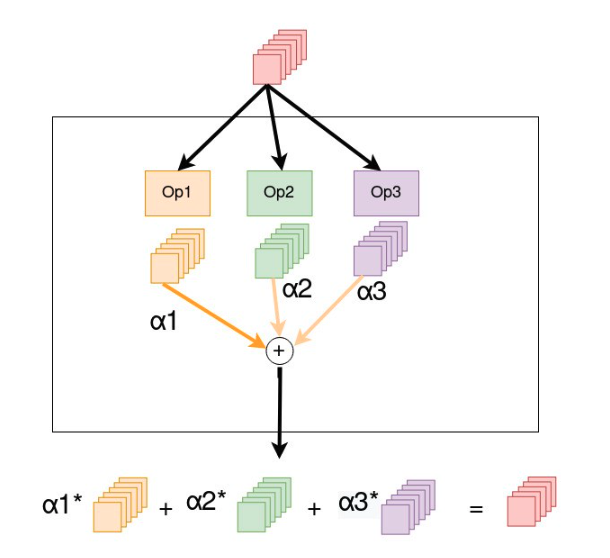

The task of architecture search then reduces to learning a set of continuous variables $\alpha=\left\{\alpha^{(i, j)}\right\}$.

**Learning the architecture $↔$ Learning the set of continuous variables $\alpha=\left\{\alpha^{(i, j)}\right\}$**.

At the end of the search, an optimal mixing of operations between each node is found:

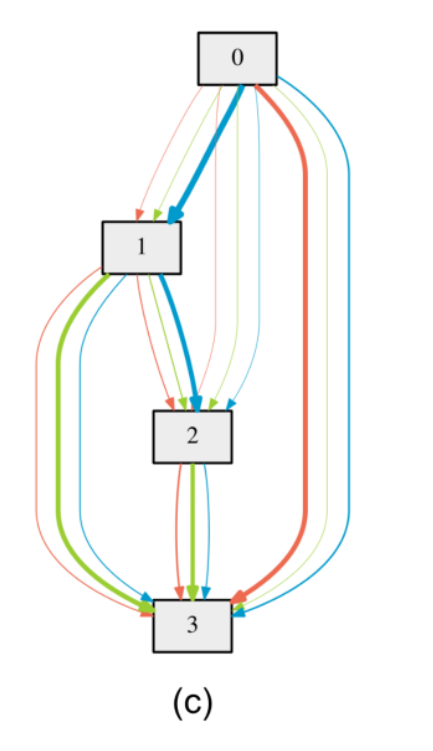

At the end of search, a discrete architecture can be obtained by replacing each mixed operation with the most likely operation, i.e., $o^{(i, j)}=\operatorname{argmax}_{o \in \mathcal{O}} \alpha_o^{(i, j)}$. We can also opt for a mixing of the top-k operations for a given pair of nodes.

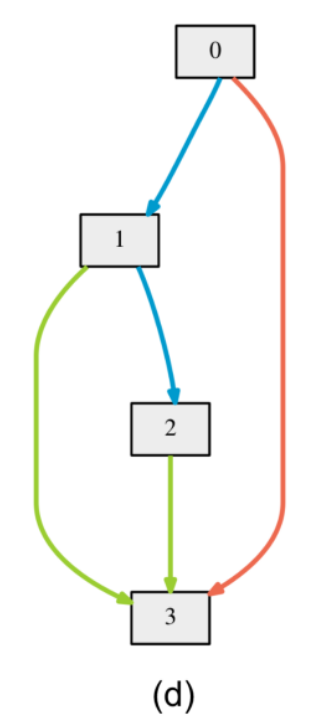

We continue to move forward, but still we do not have explained how to perform the optimisation.

The goal is to jointly learn the architecture $α$ and the weights $w$ within all the mixed operations. Indeed, the tasks of finding the optimal architecture and weights are strongly intertwined.

Denote by $\mathcal{L}_{\text {train}}$ and $\mathcal{L}_{\text {val}}$ the training and the validation loss, respectively.

The choice here is to find $α^{*}$ that minimises the validation loss $\mathcal{L}_{\text {val}}(w^{*},α^{*})$ where the weights $w^{*}$ associated with the architecture are obtained by minimising the training loss $w^*=\operatorname{argmin}_w \mathcal{L}_{\text {train }}\left(w, \alpha^*\right)$:

$\begin{array}{cl}\min _\alpha & \mathcal{L}_{\text {val }}\left(w^*(\alpha), \alpha\right) \\ \text { s.t. } & w^*(\alpha)=\operatorname{argmin}_w \mathcal{L}_{\text {train }}(w, \alpha)\end{array}$

This is called a **bilevel optimisation** problem, and the mathematical framework can be found [here](https://arxiv.org/pdf/1705.06270.pdf).

There is a computational problem in this equation. To get optimal convolution weights we need to train the network by minimizing training loss by updating convolution weights. This means every time alpha is updated minimization of training step is required. This will make network training infeasible.

**The idea is to approximate $w^*(α)$ by adapting w using only a single training step, without solving the inner optimization completely by training until convergence:**

$\nabla_\alpha \mathcal{L}_{\text {val }}\left(w^*(\alpha), \alpha\right) \approx \nabla_\alpha \mathcal{L}_{\text {val }}\left(w-\xi \nabla_w \mathcal{L}_{\text {train }}(w, \alpha), \alpha\right) = \nabla_\alpha \mathcal{L}_{\text {val }}(w', \alpha)$

where $w' = w - \xi \nabla_w \mathcal{L}_{\text {train }}(w,\alpha)$

<div class="alert alert-warning">

**Exercise**

Now that you know the structure and the optimisation trick used by DARTS, implement the pseudo-code for the joint optimisation of $\alpha$ and $w$. The choice of the criterion of convergence can be replaced by a `while not converged do` loop.
</div>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>

Algorithm: Create a mixed operation $\bar{o}^{(i, j)}$ parametrized by $\alpha^{(i, j)}$ for each edge $(i, j)$
while not converged do
1. Update architecture $\alpha$ by descending $\nabla_\alpha \mathcal{L}_{\text {val }}\left(w-\xi \nabla_w \mathcal{L}_{\text {train }}(w, \alpha), \alpha\right)$
( $\xi=0$ if using first-order approximation)
2. Update weights $w$ by descending $\nabla_w \mathcal{L}_{\text {train }}(w, \alpha)$

Derive the final architecture based on the learned $\alpha$.
</details>

<div class="alert alert-warning">

**Exercise**

Here is an application of the bilevel optimisation on this example taken from the paper.

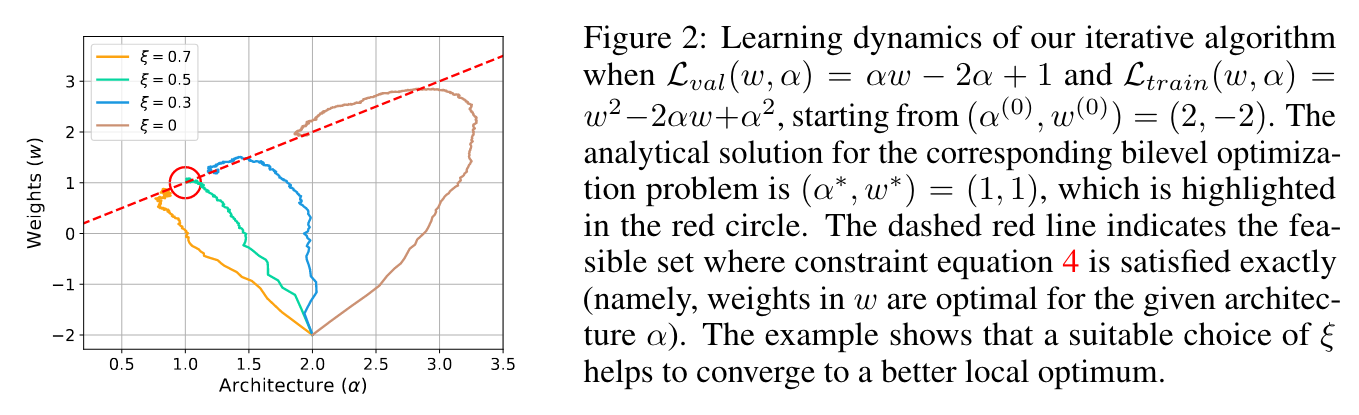

Try to implement the previous pseudo-code and try to come up with results and visuals similar to the ones from the paper. Play with the optimisation hyperparameters.

Comment.
</div>

In [131]:
# ##### SOLUTIONS #####

# # We first define the different functions, that can be here computed analytically
# import numpy as np
# import matplotlib.pyplot as plt

# def validation_loss(alpha, weight):
#   return alpha*weight - 2*alpha + 1

# def training_loss(alpha, weight):
#   return weight**2 - 2*alpha*weight + alpha**2

# def validation_loss_alpha_gradient(alpha, weight):
#   return weight - 2

# def training_loss_weight_gradient(alpha, weight):
#   return 2*weight - 2*alpha

In [132]:
# # We then perform the optimisation
# maximum_iterations = 100
# epsilon = 0.1
# counter = 0

# alpha = 2
# weight = -2
# solution = np.array([alpha, weight])
# solutions = solution

# # The true solution can also be derived analytically
# true_solution = np.array([1, 1])

# ##### Parameters of the optimisation to be tuned #####
# inner_learning_rate = 0.8
# outer_learning_rate = 0.3

# while np.linalg.norm(solution-true_solution) > epsilon and counter < maximum_iterations:
#   alpha = alpha - outer_learning_rate*validation_loss_alpha_gradient(alpha, weight - inner_learning_rate*training_loss_weight_gradient(alpha, weight))
#   weight = weight - outer_learning_rate*training_loss_weight_gradient(alpha, weight)
#   solution = np.array([alpha, weight])
#   solutions = np.vstack((solutions, solution))
#   counter +=1

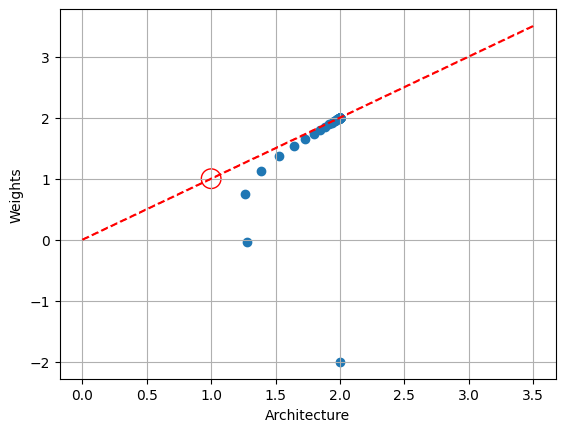

In [133]:
# number_of_samples = 1000

# architectures = np.linspace(0, 3.5, number_of_samples)
# weights = np.linspace(-2, 4, number_of_samples)

# # We can find the feasible set where the constraint equation is satisfied exactly
# feasible_set = []
# for architecture in architectures:
#   arg_min = min(weights, key=lambda w: training_loss(w, architecture))
#   feasible_set.append(arg_min)

# # We draw the evolution of the optimisation
# plt.plot(architectures, feasible_set, 'r--')
# plt.scatter(solutions[:, 0], solutions[:, 1])
# plt.scatter(1, 1, color='red', facecolor='none', marker='o', s=200)
# plt.xlabel('Architecture')
# plt.ylabel('Weights')
# plt.grid(True)

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>
The algorithm converges, but it does not converge to the best answer.

This goes to show that bilevel optimisation is not so straightforward, and that the optimisation hyperparameters have to be chosen carefully in order to get the best results.
Unfortunately, the paper does not precisely describe the exact way it is doing it, notably the choice of the outer optimisation learning rate.

However, we can still find the same trend of the curves depending on the choice of the inner learning rate. 

All this show that a suitable choice of the different learning rates help to converge to a better local optimum.
</details>

In the previous example, we could easily derive the different gradients, but this far to be always the case.

This is not the heart of the paper, but there are some little tricks used to improve the complexity of the algorithm used to compute them. The focus is on the way to compute effectively $\nabla_\alpha \mathcal{L}_{\text {val }}(w', \alpha)$. If you are interested into chain rules and finite differences, have a look at [this article](https://mythrex.github.io/math_behind_darts/) that provides a step by step explanation of this computation.

## Experiments and results

The paper conducted experiments both on the CIFAR-10 (computer vision) and PTB (NLP) datasets, so as to test respectively the convolutional and the recurrent cells.

They divided the experiments in two steps:

- The first step search for the cell architectures using DARTS, and determine the best cells based on their validation performance.

- In the second step, they use these cells to construct larger architectures, which they train from scratch and report their performance on the test set.

In the end, there is still a high degree of freedom, in the choice of the different operations, the number of nodes per cell, the arrangement of cells...

All their choices are detailed in [the original paper](https://arxiv.org/abs/1806.09055).

Their models both match or outperform the state-of-the-art non-differentiable architecture search methods on image classification and language modeling tasks with remarkable efficiency improvement (several orders of magnitude).

They also proved the scalability of their models by evaluating them respectively on ImageNet and WikiText-2.

## Summary

In this notebook, we have we have learnt that:

- Neural Architecture Search aims at incorporating the architecture search into the hyperparameters search, in some way.

- In this framework, a network consists of cells, which are made up of nodes themselves.

- Learning the architecture $↔$ Learning the set of continuous variables $\alpha=\left\{\alpha^{(i, j)}\right\}$.

- DARTS runs as follows:

  a) Operations on the edges are initially unknown.

  b) Placing a mixture of candidate operations on each edge (continuous relaxation).

  c) Joint optimization of the mixing probabilities and the network weights by solving a bilevel optimization problem.

  d) Inducing the final architecture from the learned mixing probabilities.


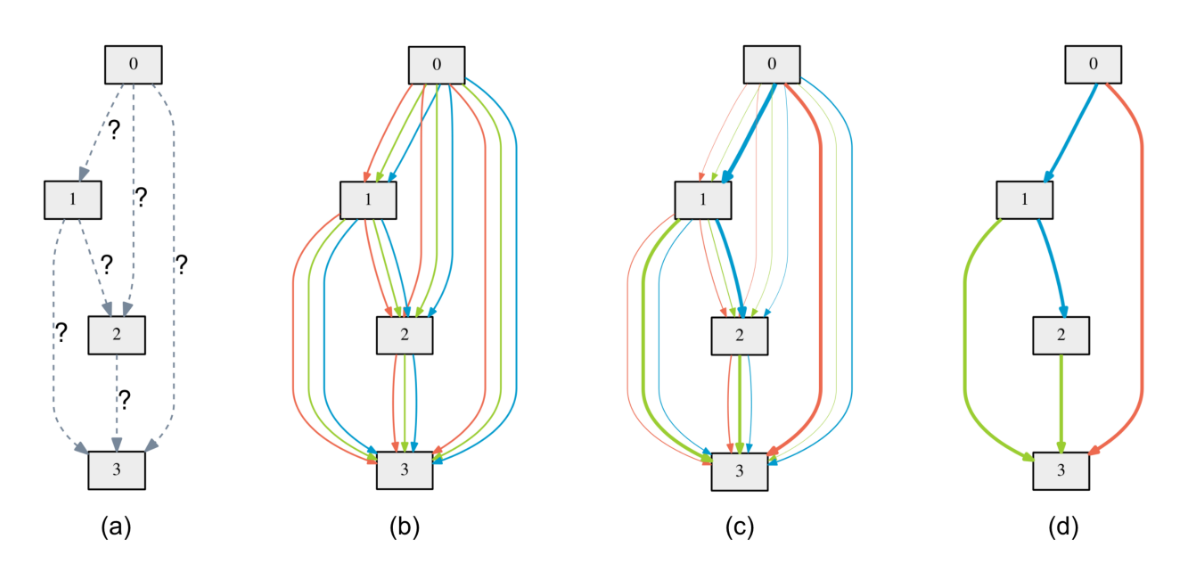

- In place of entirely solving the inner optimisation of the bilevel problem, $w^* (\alpha)$ is approximated using a single step of gradient.

- The choices of the learning rate is not easy for solving the gradient bilevel problem.

- Gradient-based architecture search achieves highly competitive results on CIFAR-10 and outperforms the state of the art on PTB, while proving to be transferable to other datasets.

## Sources

I want to thank Shivam Kaushik whose [article](https://towardsdatascience.com/intuitive-explanation-of-differentiable-architecture-search-darts-692bdadcc69c) on DARTS inspired me for the different illustrations shown in this notebook.